In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
from datetime import timedelta
import numpy as np
from scipy.io import netcdf
from netCDF4 import Dataset
import pandas as pd

from mpl_toolkits.basemap import Basemap

import csv
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle as pickle

import time

filenames = {'U': "../MITgcm_data/UV*.cdf",
             'V': "../MITgcm_data/UV*.cdf"}

In [2]:
import parcels
print(parcels.__file__)
from parcels import rng as random
import math

/Users/mho/anaconda3/envs/py2_parcels/lib/python2.7/site-packages/parcels/__init__.pyc


In [3]:
variables = {'U': 'U',
             'V': 'V'}
dimensions = {'time': 'TIME1','depth': 'DEPTH_T1_4',
              'lat': 'LATITUDE_T',
              'lon': 'LONGITUDE_U'}

In [5]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [7]:
# Just check the fieldset shape
fieldset.V.data.shape

(245, 4, 504, 876)

In [8]:
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()

In [9]:
def turbVal(particle, fieldset, time, dt):
    # This if-statement is meant to trigger when the current time is a quarter interval of the model timestep
    # but I'm not sure it's working... need to double-check
    if math.fmod(time,dt/4) == 0:
        horDiff = 100
        uturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1) # Important! Should this be random.random()???
        # should set random seed somewhere too...?
        particle.lat += uturb * dt/1.1e5
        vturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1)
        particle.lon += vturb * dt/1.1e5

In [10]:
# All 18  origin points

lat = [31.082, 29.152, 32.794, 30.900, 27.781, 27.952, 18.640, 29.661, 24.174, 21.020, 34.102, 33.462, 31.458, 32.024, 15.509, 18.906, 17.074, 16.555]
lon = [176.366, 191.072, 197.52, 193.91, 178.991, 194.899, 178.040, 208.099, 191.298, 187.602, 188.077, 181.109, 183.82, 179.190, 180.468, 189.375, 206.097, 190.914]

In [12]:
# How many times to repeat
npart = 100

In [13]:
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle,
                   lon=np.tile(lon,npart), lat=np.tile(lat,npart))

In [14]:
k_turbVal = pset.Kernel(turbVal)        # casting the turbVal function to a kernel object

In [15]:
now = time.time()

# Set random seed
random.seed(123456)

days = 244
runtime = timedelta(days=days)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle,
                   lon=np.tile(lon,npart), lat=np.tile(lat,npart))
pset.execute(AdvectionRK4 + k_turbVal, # Add Turbulence to Advection!
             runtime=runtime,
             dt=timedelta(hours=1),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pset.ParticleFile(name="{}n_Turbulence_{}repeats_{}days".format(len(lat),npart,days),
                                           outputdt=timedelta(days=1)))   # output is low resolution (1 day)
time_elapsed = time.time()-now
print('time elapsed (s): ', time_elapsed)

INFO: Compiled random ==> /var/folders/nj/pymsyw7n28qdntb958tl337c0000gp/T/parcels-502/random.so
INFO: Compiled JITParticleAdvectionRK4turbVal ==> /var/folders/nj/pymsyw7n28qdntb958tl337c0000gp/T/parcels-502/f59a26fed3bf225fb9a65ca612fe4c8f.so


('time elapsed (s): ', 90.6280210018158)


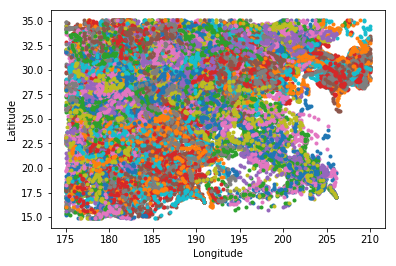

<module 'matplotlib.pyplot' from '/Users/mho/anaconda3/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [16]:
plotTrajectoriesFile("{}n_Turbulence_{}repeats_{}days.nc".format(len(lat),npart,days))

In [6]:
# PLOT WITH BASEMAP AND BATHYMETRY DATA

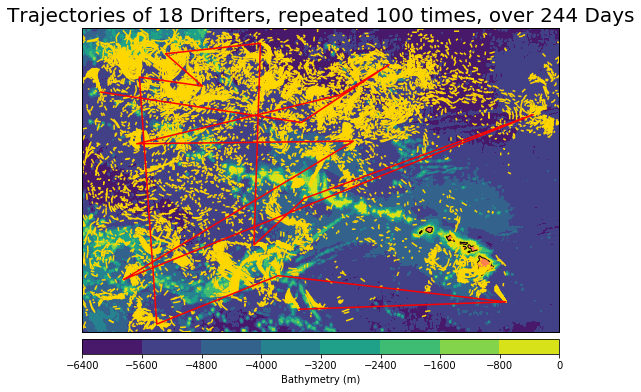

In [18]:
pfile = Dataset('18n_Turbulence_100repeats_244days.nc', 'r')
bath_data = Dataset('../HAWc0.04_depth.cdf')

# For determining the boundaries of the basemap
lon = pfile.variables['lon']

# print('min long: ', np.nanmin(lon))
# print('max long: ', np.nanmax(lon))

lat = pfile.variables['lat']
# print('min lat: ', np.nanmin(lat))
# print('max lat: ', np.nanmax(lat))

# Set up the figure, change figsize as needed
plt.figure(figsize=(12,6))

# Set up mapper with a Basemap of coastal boundaries for Hawaii
mapper = Basemap(projection='merc',
                 llcrnrlon=np.nanmin(lon),
                 llcrnrlat=np.nanmin(lat),
                 urcrnrlon=np.nanmax(lon),
                 urcrnrlat=np.nanmax(lat),
                 resolution='i')
mapper.drawmapboundary()
mapper.drawcoastlines()
mapper.fillcontinents(color='coral',lake_color='aqua')

# plot each trajectory separately, in gold color
# documentation: https://matplotlib.org/basemap/index.html
for i in range(lon.shape[0]):
    lons = lon[:][i]
    lats = lat[:][i]
    mapper.plot(np.array(lons), np.array(lats), latlon=True, color='gold')

    
# Plot 18 origin points

origin_lat = [31.082, 29.152, 32.794, 30.900, 27.781, 27.952, 18.640, 29.661, 24.174, 21.020, 34.102, 33.462, 31.458, 32.024, 15.509, 18.906, 17.074, 16.555]
origin_lon = [176.366, 191.072, 197.52, 193.91, 178.991, 194.899, 178.040, 208.099, 191.298, 187.602, 188.077, 181.109, 183.82, 179.190, 180.468, 189.375, 206.097, 190.914]
mapper.plot(origin_lon, origin_lat, latlon=True, color='red')

# Set up processing for bathymetry data
lats = bath_data.variables['Y_B'][:]
lons = bath_data.variables['X_B'][:]
BATHY_OUT = bath_data.variables['BATHY_OUT'][:] # etopo1 bedrock global relief model-topography/bathymetry (m)

lons,lats= np.meshgrid(lons,lats)
x,y = mapper(lons,lats)

# Create contour object and add to the mapper
depth = mapper.contourf(x,y,BATHY_OUT[0])

# Add legend
cb = mapper.colorbar(depth,"bottom", size="5%", pad="2%")
cb.set_label('Bathymetry (m)')

# Change plot titles
plt.title('Trajectories of 18 Drifters, repeated 100 times, over 244 Days', fontsize=20)
plt.savefig('n18_r100_d244_2.png')

plt.show()